<a href="https://www.kaggle.com/code/samithsachidanandan/many-to-many-pos-tagging?scriptVersionId=283651620" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install protobuf==3.20.* --force-reinstall --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0


In [2]:
import numpy as np
import os
import shutil
import tensorflow as tf

2025-12-03 15:35:47.420939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764776147.593325      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764776147.638752      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def download_and_read(dataset_dir, num_pairs=None):
    sent_filename = os.path.join(dataset_dir, "treebank-sents.txt")
    poss_filename = os.path.join(dataset_dir, "treebank-poss.txt")
    if not(os.path.exists(sent_filename) and os.path.exists(poss_filename)):
        import nltk
        if not os.path.exists(dataset_dir):
            os.makedirs(dataset_dir)
        fsents = open(sent_filename, "w")
        fposs = open(poss_filename, "w")
        sentences = nltk.corpus.treebank.tagged_sents()
        for sent in sentences:
            fsents.write(" ".join([w for w, p in sent]) + "\n")
            fposs.write(" ".join([p for w, p in sent]) + "\n")
        fsents.close()
        fposs.close()
    sents, poss = [], []
    with open(sent_filename, "r") as fsent:
        for idx, line in enumerate(fsent):
            sents.append(line.strip())
            if num_pairs is not None and idx >= num_pairs:
                break
        with open(poss_filename, "r") as fposs:
            for idx, line in enumerate(fposs):
                poss.append(line.strip())
                if num_pairs is not None and idx >= num_pairs:
                    break
    return sents, poss
sents, poss = download_and_read("./datasets")
assert(len(sents) == len(poss))
print("# of records: {:d}".format(len(sents)))
        

# of records: 3914


In [4]:
def tokenize_and_build_vocab(texts, vocab_size=None, lower=True):
    if vocab_size is None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=lower)
    else:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=vocab_size+1, oov_token="UNK", lower=lower)
    tokenizer.fit_on_texts(texts)
    if vocab_size is not None:
        # additional workaround, see issue 8092
        # https://github.com/keras-team/keras/issues/8092
        tokenizer.word_index = {e:i for e, i in
            tokenizer.word_index.items() if
            i <= vocab_size+1 }
    word2idx = tokenizer.word_index
    idx2word = {v:k for k, v in word2idx.items()}
    return word2idx, idx2word, tokenizer
    
word2idx_s, idx2word_s, tokenizer_s = tokenize_and_build_vocab(sents, vocab_size=9000)
word2idx_t, idx2word_t, tokenizer_t = tokenize_and_build_vocab(poss, vocab_size=38, lower=False)
source_vocab_size = len(word2idx_s)
target_vocab_size = len(word2idx_t)
print("vocab sizes (source): {:d}, (target): {:d}".format(source_vocab_size, target_vocab_size))
    
    

vocab sizes (source): 9001, (target): 39


In [5]:
sequence_lengths = np.array([len(s.split()) for s in sents])
print([(p, np.percentile(sequence_lengths, p))
    for p in [75, 80, 90, 95, 99, 100]])
[(75, 33.0), (80, 35.0), (90, 41.0), (95, 47.0), (99, 58.0), (100, 271.0)]

[(75, 33.0), (80, 35.0), (90, 41.0), (95, 47.0), (99, 58.0), (100, 271.0)]


[(75, 33.0), (80, 35.0), (90, 41.0), (95, 47.0), (99, 58.0), (100, 271.0)]

In [6]:
max_seqlen = 271
# convert sentences to sequence of integers
sents_as_ints = tokenizer_s.texts_to_sequences(sents)
sents_as_ints = tf.keras.preprocessing.sequence.pad_sequences(sents_as_ints, maxlen=max_seqlen, padding="post")


poss_as_ints = tokenizer_t.texts_to_sequences(poss)
poss_as_ints = tf.keras.preprocessing.sequence.pad_sequences(poss_as_ints, maxlen=max_seqlen, padding="post")


poss_as_catints = tf.keras.utils.to_categorical(poss_as_ints, num_classes=target_vocab_size)

dataset = tf.data.Dataset.from_tensor_slices((sents_as_ints, poss_as_catints))

idx2word_s[0], idx2word_t[0] = "PAD", "PAD"

# split into training, validation, and test datasets
dataset = dataset.shuffle(10000)
test_size = len(sents) // 3
val_size = (len(sents) - test_size) // 10

test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)

# create batches
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


I0000 00:00:1764776166.193278      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:

def masked_accuracy():
    def masked_accuracy_fn(ytrue, ypred):
        ytrue = tf.keras.backend.argmax(ytrue, axis=-1)
        ypred = tf.keras.backend.argmax(ypred, axis=-1)
        mask = tf.keras.backend.cast(
            tf.keras.backend.not_equal(ypred, 0), tf.int32)
        matches = tf.keras.backend.cast(
            tf.keras.backend.equal(ytrue, ypred), tf.int32) * mask
        numer = tf.keras.backend.sum(matches)
        denom = tf.keras.backend.maximum(tf.keras.backend.sum(mask), 1)
        accuracy = numer / denom
        return accuracy
    return masked_accuracy_fn

class POSTaggingModel(tf.keras.Model):
    def __init__(self, source_vocab_size, target_vocab_size, embedding_dim, max_seqlen, rnn_output_dim, **kwargs):
        super(POSTaggingModel, self).__init__(**kwargs)
        self.embed = tf.keras.layers.Embedding(source_vocab_size, embedding_dim)  # Removed input_length
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.rnn = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_output_dim, return_sequences=True))
        self.dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(target_vocab_size))
        self.activation = tf.keras.layers.Activation("softmax")
        
    def call(self, x):
        x = self.embed(x)
        x = self.dropout(x)
        x = self.rnn(x)
        x = self.dense(x)
        x = self.activation(x)
        return x

embedding_dim = 128
rnn_output_dim = 256
model = POSTaggingModel(source_vocab_size, target_vocab_size, embedding_dim, max_seqlen, rnn_output_dim)


model(tf.keras.Input(shape=(max_seqlen,), dtype=tf.int32))

model.summary()
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy", masked_accuracy()]
)

Model: "pos_tagging_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 271, 128)       │     1,152,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 271, 512)       │       592,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 271, 39)        │        20,007 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,765,031 (6.73 MB)

 Trainable params: 1,765,031 (6.73 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
num_epochs = 50
best_model_file = "/kaggle/working/best_model.keras"
logs_dir = "/kaggle/working/logs"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    best_model_file,
    save_best_only=True,  
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[checkpoint, tensorboard, early_stopping]
)

Epoch 1/50


I0000 00:00:1764776189.313021      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8599 - loss: 0.7517 - masked_accuracy_fn: 0.1626
Epoch 1: val_loss improved from inf to 0.24473, saving model to /kaggle/working/best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 29s 157ms/step - accuracy: 0.8606 - loss: 0.7468 - masked_accuracy_fn: 0.1631 - val_accuracy: 0.9317 - val_loss: 0.2447 - val_masked_accuracy_fn: 0.2399
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9389 - loss: 0.2226 - masked_accuracy_fn: 0.2864
Epoch 2: val_loss improved from 0.24473 to 0.20057, saving model to /kaggle/working/best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9389 - loss: 0.2225 - masked_accuracy_fn: 0.2868 - val_accuracy: 0.9453 - val_loss: 0.2006 - val_masked_accuracy_fn: 0.3997
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9483 - loss: 0.1874 - masked_accuracy_fn: 0.4127
Epoch 3: val_loss improved from 0.20057 to 0.15298, saving model to /kaggle/working/best_model.keras
74/74 ━━━━━━

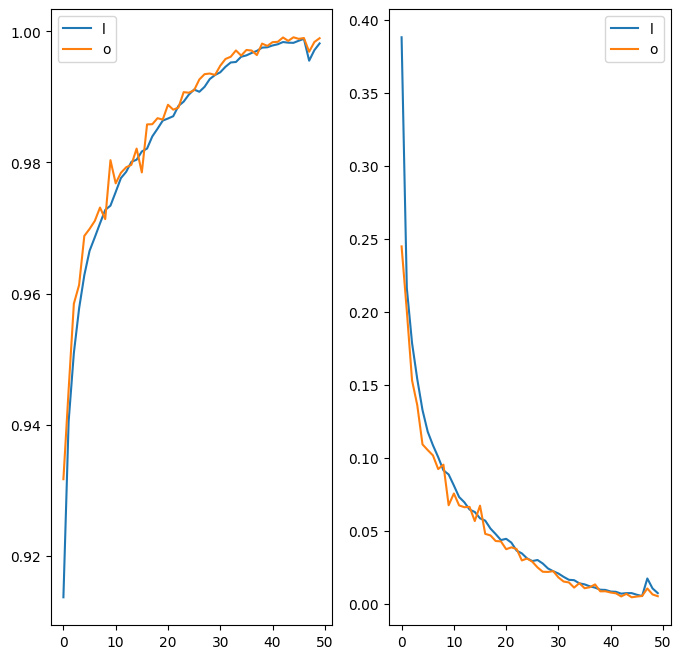

In [9]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend('lower right')


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend('lower right')
plt.show()